# Part 3: Compression

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)

import sys
import os
# Add the directory containing callbacks.py to sys.path
sys.path.append(os.path.join(os.getcwd(), "hls4ml-tutorial_OPENML"))

# Simulate sourcing the script to set variables (as a fallback)
os.environ['XILINX_VITIS'] = '/opt/local/Vitis_HLS/2024.1'  # Adjust this path as needed
# Update the PATH variable
os.environ['PATH'] = os.path.join(os.environ['XILINX_VITIS'], 'bin') + ':' + os.environ.get('PATH', '')

2025-02-26 00:56:05.461006: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Fetch the jet tagging dataset from Open ML

In [2]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

## Now construct a model
We'll use the same architecture as in part 1: 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [4]:
model = Sequential()
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

## Train sparse
This time we'll use the Tensorflow model optimization sparsity to train a sparse model (forcing many weights to '0'). In this instance, the target sparsity is 75%

In [5]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

pruning_params2 = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.6, begin_step=2000, frequency=100)}
model2 = prune.prune_low_magnitude(model, **pruning_params2)

pruning_params3 = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.9, begin_step=2000, frequency=100)}
model3 = prune.prune_low_magnitude(model, **pruning_params3)

## Train the model
We'll use the same settings as the model for part 1: Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_2'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

### Training all 3 will take a minute or so

In [7]:
train = False
if train:
    # Model 1 - 75% sparsity
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='/home/hep/lr1424/hls4ml-tutorial_OPENML/model_2',
    )
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=10,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    model = strip_pruning(model)
    model.save('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_2/KERAS_check_best_model.h5')
    
    # Model 2 - 60% sparsity
    adam = Adam(lr=0.0001)
    model2.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='/home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.1',
    )
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model2.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=10,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
    # Save the model2 again but with the pruning 'stripped' to use the regular layer types
    model2 = strip_pruning(model2)
    model2.save('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.1/KERAS_check_best_model.h5')
    
    # Model 3 - 90% sparsity
    adam = Adam(lr=0.0001)
    model3.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='/home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.2',
    )
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model3.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=10,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
    # Save the model3 again but with the pruning 'stripped' to use the regular layer types
    model3 = strip_pruning(model3)
    model3.save('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.2/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model

    model = load_model('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_2/KERAS_check_best_model.h5')
    model2 = load_model('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.1/KERAS_check_best_model.h5')
    model3 = load_model('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.2/KERAS_check_best_model.h5')

Epoch 1/10
  1/487 [..............................] - ETA: 5:00 - loss: 0.6919 - accuracy: 0.7656WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0020s vs `on_train_batch_end` time: 0.0023s). Check your callbacks.


482/487 [============================>.] - ETA: 0s - loss: 0.7087 - accuracy: 0.7585
***callbacks***
saving losses to /home/hep/lr1424/hls4ml-tutorial_OPENML/model_2/losses.log

Epoch 1: val_loss improved from inf to 0.71088, saving model to /home/hep/lr1424/hls4ml-tutorial_OPENML/model_2/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.71088, saving model to /home/hep/lr1424/hls4ml-tutorial_OPENML/model_2/KERAS_check_best_model_weights.h5

Epoch 1: saving model to /home/hep/lr1424/hls4ml-tutorial_OPENML/model_2/KERAS_check_model_last.h5

Epoch 1: saving model to /home/hep/lr1424/hls4ml-tutorial_OPENML/model_2/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 4ms/step - loss: 0.7086 - accuracy: 0.7586 - val_loss: 0.7109 - val_accuracy: 0.7577 - lr: 0.0010
Epoch 2/10
 47/487 [=>............................] - ETA: 0s - loss: 0.6989 - accuracy: 0.7609

/home/hep/lr1424/miniforge3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


481/487 [============================>.] - ETA: 0s - loss: 0.7034 - accuracy: 0.7602
***callbacks***
saving losses to /home/hep/lr1424/hls4ml-tutorial_OPENML/model_2/losses.log

Epoch 2: val_loss improved from 0.71088 to 0.70610, saving model to /home/hep/lr1424/hls4ml-tutorial_OPENML/model_2/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 0.71088 to 0.70610, saving model to /home/hep/lr1424/hls4ml-tutorial_OPENML/model_2/KERAS_check_best_model_weights.h5

Epoch 2: saving model to /home/hep/lr1424/hls4ml-tutorial_OPENML/model_2/KERAS_check_model_last.h5

Epoch 2: saving model to /home/hep/lr1424/hls4ml-tutorial_OPENML/model_2/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 3ms/step - loss: 0.7034 - accuracy: 0.7602 - val_loss: 0.7061 - val_accuracy: 0.7596 - lr: 0.0010
Epoch 3/10
471/487 [============================>.] - ETA: 0s - loss: 0.7010 - accuracy: 0.7611
***callbacks***
saving losses to /home/hep/lr1424/hls4ml-tu

Epoch 1/10
  1/487 [..............................] - ETA: 17:37 - loss: 1.6865 - accuracy: 0.1914WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0026s vs `on_train_batch_end` time: 0.0047s). Check your callbacks.


483/487 [============================>.] - ETA: 0s - loss: 0.9570 - accuracy: 0.6871
***callbacks***
saving losses to /home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.1/losses.log

Epoch 1: val_loss improved from inf to 0.82673, saving model to /home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.1/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.82673, saving model to /home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.1/KERAS_check_best_model_weights.h5

Epoch 1: saving model to /home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.1/KERAS_check_model_last.h5

Epoch 1: saving model to /home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 4s 4ms/step - loss: 0.9559 - accuracy: 0.6874 - val_loss: 0.8267 - val_accuracy: 0.7340 - lr: 0.0010
Epoch 2/10
481/487 [============================>.] - ETA: 0s - loss: 0.7953 - accuracy: 0.7425
***callbacks***
saving losses to /home/hep/lr1424/hls4ml-

Epoch 1/10
  1/487 [..............................] - ETA: 12:37 - loss: 0.6974 - accuracy: 0.7734WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0026s vs `on_train_batch_end` time: 0.0045s). Check your callbacks.


477/487 [============================>.] - ETA: 0s - loss: 0.7111 - accuracy: 0.7570
***callbacks***
saving losses to /home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.2/losses.log

Epoch 1: val_loss improved from inf to 0.71337, saving model to /home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.2/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.71337, saving model to /home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.2/KERAS_check_best_model_weights.h5

Epoch 1: saving model to /home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.2/KERAS_check_model_last.h5

Epoch 1: saving model to /home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.2/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 4s 4ms/step - loss: 0.7109 - accuracy: 0.7571 - val_loss: 0.7134 - val_accuracy: 0.7564 - lr: 0.0010
Epoch 2/10
485/487 [============================>.] - ETA: 0s - loss: 0.7080 - accuracy: 0.7576
***callbacks***
saving losses to /home/hep/lr1424/hls4ml-

## Check sparsity
Make a quick check that the model was indeed trained sparse. We'll just make a histogram of the weights of the 1st layer, and hopefully observe a large peak in the bin containing '0'. Note logarithmic y axis.

% of zeros = 0.0


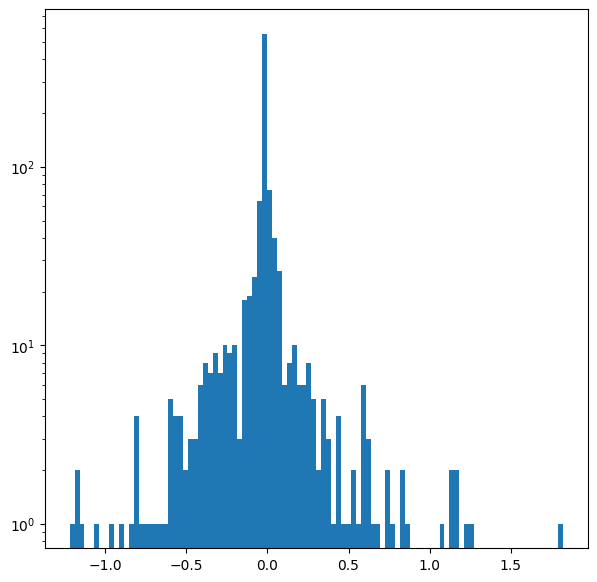

In [8]:
w = model.layers[0].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7, 7))
plt.bar(b[:-1], h, width=b[1] - b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w == 0) / np.size(w)))

## Check performance
How does this 75% sparse model compare against the unpruned model? Let's report the accuracy and make a ROC curve. The pruned model is shown with solid lines, the unpruned model from part 1 is shown with dashed lines.
**Make sure you've trained the model from part 1**

### This will take 2 mins

In [9]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

model_ref = load_model('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/KERAS_check_best_model.h5')

y_ref = model_ref.predict(X_test)
y_prune = model.predict(X_test)
y_prune2 = model2.predict(X_test)
y_prune3 = model3.predict(X_test)

5188/5188 [==============================] - 4s 766us/step


Accuracy unpruned: 0.7340240963855422
Accuracy 75%:   0.7607469879518072
Accuracy 60%:   0.7597108433734939
Accuracy 90%:   0.7597108433734939


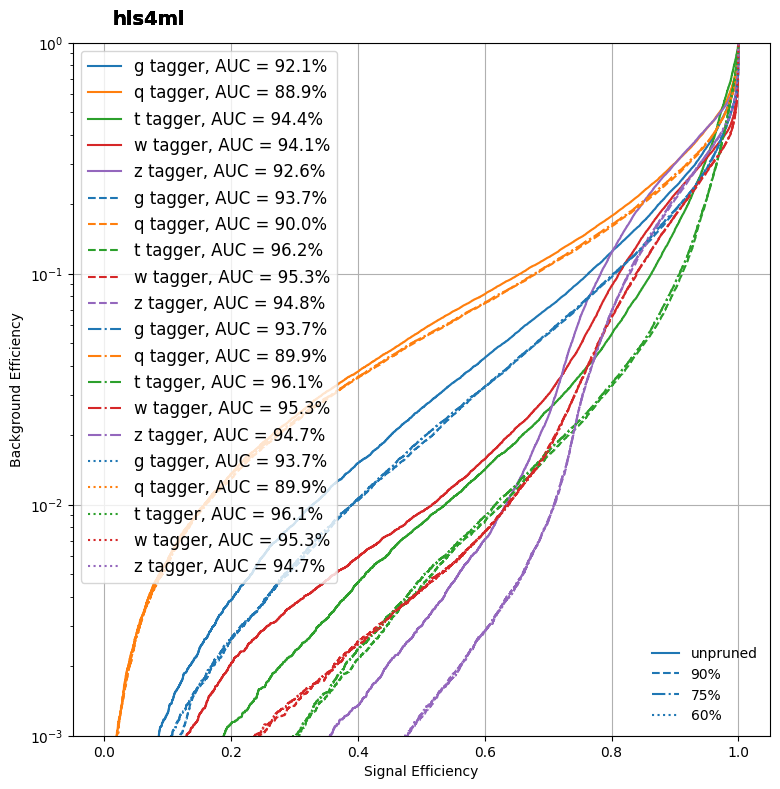

In [10]:
print("Accuracy unpruned: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy 75%:   {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_prune, axis=1))))
print("Accuracy 60%:   {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_prune2, axis=1))))
print("Accuracy 90%:   {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_prune3, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_prune, classes, linestyle='--')
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_prune2, classes, linestyle='-.')
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_prune3, classes, linestyle=':')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--'), Line2D([0], [0], ls='-.'), Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['unpruned', '90%', '75%', '60%'], loc='lower right', frameon=False)
ax.add_artist(leg)

## Convert the model to FPGA firmware with hls4ml
Let's use the default configuration: `ap_fixed<16,6>` precision everywhere and `ReuseFactor=1`, so we can compare with the part 1 model. We need to use `strip_pruning` to change the layer types back to their originals.

**The synthesis will take a while**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_2/hls4ml_prj/vitis_hls.log`

In [11]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model', backend='Vitis')
print(config)

# hls_model = hls4ml.converters.convert_from_keras_model(
#     model, hls_config=config, backend='Vitis', output_dir='/home/hep/lr1424/hls4ml-tutorial_OPENML/model_2/hls4ml_prj', part='xcu50-fsvh2104-2-e'
# )
# hls_model.compile()
# hls_model.build(csim=False)

hls_model_prune_75 = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='Vitis', output_dir='/home/hep/lr1424/hls4ml-tutorial_OPENML/model_2/hls4ml_prj_prune_75', part='xcu50-fsvh2104-2-e'
)
hls_model_prune_75.compile()
hls_model_prune_75.build(csim=False)

hls_model_prune_60 = hls4ml.converters.convert_from_keras_model(
    model2, hls_config=config, backend='Vitis', output_dir='/home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.1/hls4ml_prj_prune_60', part='xcu50-fsvh2104-2-e'
)
hls_model_prune_60.compile()
hls_model_prune_60.build(csim=False)

hls_model_prune_90 = hls4ml.converters.convert_from_keras_model(
    model3, hls_config=config, backend='Vitis', output_dir='/home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.2/hls4ml_prj_prune_90', part='xcu50-fsvh2104-2-e'
)
hls_model_prune_90.compile()
hls_model_prune_90.build(csim=False)


/home/hep/lr1424/miniforge3/envs/hls4ml-tutorial/lib/python3.10/site-packages/hls4ml/converters/__init__.py:28: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
{'Model': {'Precision': {'default': 'fixed<16,6>'}, 'ReuseFactor': 1, 'Strategy': 'Latency', 'BramFactor': 1000000000, 'TraceOu

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '3.621',
  'BestLatency': '14',
  'WorstLatency': '14',
  'IntervalMin': '1',
  'IntervalMax': '1',
  'BRAM_18K': '8',
  'DSP': '817',
  'FF': '8462',
  'LUT': '35326',
  'URAM': '0',
  'AvailableBRAM_18K': '2688',
  'AvailableDSP': '5952',
  'AvailableFF': '1743360',
  'AvailableLUT': '871680',
  'AvailableURAM': '640'}}

## Check the reports
Print out the reports generated by Vitis HLS. Pay attention to the Utilization Estimates' section in particular this time.

### 75% sparse model

In [12]:
hls4ml.report.read_vivado_report('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_2/hls4ml_prj_prune_75/')

Found 1 solution(s) in /home/hep/lr1424/hls4ml-tutorial_OPENML/model_2/hls4ml_prj_prune_75//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Wed Feb 26 01:01:01 2025

* Version:        2024.1 (Build 5069499 on May 21 2024)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: virtexuplusHBM
* Target device:  xcu50-fsvh2104-2-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  |  5.00 ns|  3.647 ns|     1.35 ns|
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+---------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline|
    |   min   |   max   |    min    |    max   

### 60% sparse model

In [16]:
hls4ml.report.read_vivado_report('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.1/hls4ml_prj_prune_60/')

Found 1 solution(s) in /home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.1/hls4ml_prj_prune_60//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Wed Feb 26 01:03:01 2025

* Version:        2024.1 (Build 5069499 on May 21 2024)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: virtexuplusHBM
* Target device:  xcu50-fsvh2104-2-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  |  5.00 ns|  3.621 ns|     1.35 ns|
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+---------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline|
    |   min   |   max   |    min    |    max 

### 90% sparse model

In [14]:
hls4ml.report.read_vivado_report('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.2/hls4ml_prj_prune_90/')

Found 1 solution(s) in /home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.2/hls4ml_prj_prune_90//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Wed Feb 26 01:04:59 2025

* Version:        2024.1 (Build 5069499 on May 21 2024)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: virtexuplusHBM
* Target device:  xcu50-fsvh2104-2-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  |  5.00 ns|  3.621 ns|     1.35 ns|
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+---------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline|
    |   min   |   max   |    min    |    max 

Print the report for the model trained in part 1. Remember these models have the same architecture, but the model in this section was trained using the sparsity API from tensorflow_model_optimization. Notice how the resource usage had dramatically reduced (particularly the DSPs). When Vitis HLS notices an operation like `y = 0 * x` it can avoid placing a DSP for that operation. The impact of this is biggest when `ReuseFactor = 1`, but still applies at higher reuse as well. **Note you need to have trained and synthesized the model from part 1**

In [15]:
hls4ml.report.read_vivado_report('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj')

Found 1 solution(s) in /home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Tue Feb 11 17:18:33 2025

* Version:        2024.1 (Build 5069499 on May 21 2024)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  |  5.00 ns|  3.636 ns|     1.35 ns|
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+---------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline|
    |   min   |   max   |    min    |    max    | min | ma